In [1]:
from carbon import CarbonSimulatorUI, CarbonOrderUI, P, __version__, __date__
from math import sqrt, exp, log
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [8,4]
print(f"Carbon v{__version__} ({__date__})")
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonSimulatorUI))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonOrderUI))

Carbon v2.2-BETA8 (20/Jan/2022)
CarbonSimulatorUI v2.4 (12/Jan/2023)
CarbonOrderUI v1.6 (20/Jan/2023)


# Carbon Simulation - Demo 7-1 (Sim Demo)

## Setup

In [2]:
# HTML("""
# <style>
# #notebook-container {background-color: #abc}
# </style>
# """)

In [3]:
# style_list = ['default', 'classic'] + sorted(
#     style for style in plt.style.available
#     if style != 'classic' and not style.startswith('_'))
# style_list

#### Define parameters

In [4]:
# spot process
pair = "ETH/USDC"
vol = 0.5
time = 1
mu = 0
steps = 100

# range
spot0      = 1500
w0         = 0.05
w1         = 2*w0
amt_usdc   = 1000
amt_eth    = 1

In [5]:
# derived numbers
p_buy_a = spot0*(1-w0)
p_buy_b = spot0*(1-w0)*(1-w1)
p_sell_a = spot0*(1+w0)
p_sell_b = spot0*(1+w0)*(1+w1)
print(f"ETH -- BID {p_buy_b:.1f}-{p_buy_a:.1f}, SPOT {spot0:.1f}, ASK {p_sell_a:.1f}-{p_sell_b:.1f}")

ETH -- BID 1282.5-1425.0, SPOT 1500.0, ASK 1575.0-1732.5


### Calculate derived parameters and set up objects

In [6]:
dt = time/steps
time_r = np.array([i*dt for i in range(steps+1)])
sqrt_dt = sqrt(dt)
mudt = mu*dt
vol_sqrt_dt = vol*sqrt_dt
half_sig2_dt = 0.5*vol*vol*dt
print(sqrt_dt, mudt, vol_sqrt_dt)

0.1 0.0 0.05


In [7]:
Sim = CarbonSimulatorUI(pair="ETH/USDC")
Sim.add_strategy("ETH", amt_eth, p_sell_a, p_sell_b, amt_usdc, p_buy_a, p_buy_b)
Sim.state()["orders"]

,id,pair,tkn,y_int,y,y_unit,disabled,p_start,p_end,p_marg,p_unit,lid
0,0,ETHUSDC,ETH,1.0,1.0,ETH,False,1575.0,1732.5,1575.0,USDC per ETH,1
1,1,ETHUSDC,USDC,1000.0,1000.0,USDC,False,1425.0,1282.5,1425.0,USDC per ETH,0


### Generate path

buy ETH 1425.0-1282.5, sell ETH 1575.0-1732.5


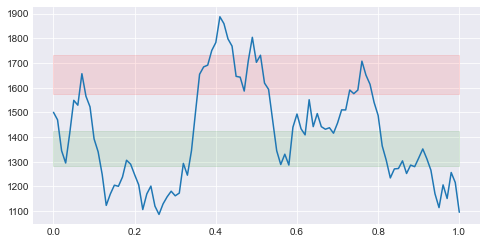

In [8]:
rng = np.random.default_rng()
increments = rng.lognormal(mean=mudt-half_sig2_dt, sigma=vol_sqrt_dt, size=steps)
#multipliers = np.insert(np.cumprod(increments), 0, 1) 
#path = spot0 * multipliers
path = np.cumprod(np.insert(increments, 0, spot0))
plt.plot(time_r, path)
plt.fill_between(time_r, p_buy_a, p_buy_b, color="green", alpha=0.1)
plt.fill_between(time_r, p_sell_a, p_sell_b, color="red", alpha=0.1)
plt.grid()
print(f"buy ETH {p_buy_a:.1f}-{p_buy_b:.1f}, sell ETH {p_sell_a:.1f}-{p_sell_b:.1f}")

## Simulation using `dyfromp_f`

In [9]:
Sim = CarbonSimulatorUI(pair="ETH/USDC", verbose=False)
Sim.add_strategy("ETH", amt_eth, p_sell_a, p_sell_b, amt_usdc, p_buy_a, p_buy_b)
print(f"buy ETH {p_buy_a:.1f}-{p_buy_b:.1f}, sell ETH {p_sell_a:.1f}-{p_sell_b:.1f}")
print("-"*20)
printdots = True
#Sim.state()["orders"]
for t, spot, ix in zip(time_r, path, range(len(path))):
    
    orderuis = Sim.state()["orderuis"]
    orders_sell_eth = {k:v for k,v in orderuis.items() if v.tkn=="ETH"}
    dy_f_sell_eth = lambda p: sum(o.dyfromp_f(p) for o in orders_sell_eth.values())
    sell_eth  = dy_f_sell_eth(spot)
    
    orders_sell_usdc = {k:v for k,v in orderuis.items() if v.tkn=="USDC"}
    dy_f_sell_usdc = lambda p: sum(o.dyfromp_f(p) for o in orders_sell_usdc.values())
    sell_usdc = dy_f_sell_usdc(spot)
    
    if sell_eth > 0.0001:
        r = Sim.amm_sells("ETH", sell_eth, support_partial=True)
        failed = "" if r['success'] else "FAILED"
        print(f"ix={ix:4.0f}, spot={spot:0.1f}: sell {sell_eth:10.2f} ETH {failed}")
        printdots = True
    elif sell_usdc > 0.001:
        r = Sim.amm_sells("USDC", sell_usdc, support_partial=True)
        failed = "" if r['success'] else "FAILED"
        print(f"ix={ix:4.0f}, spot={spot:0.1f}: sell {sell_usdc:10.2f} USDC {failed}")
        printdots = True
    else:
        if printdots:
            print("...")
        printdots = False
        #print(f"ix={ix:4.0f}, spot={spot:0.1f}: ---")

o = Sim.state()["orders"]
#print(f"ix={ix:4.0f}, spot={spot:0.1f}: -- sim  finished --")
amt_eth_final = abs(float(o.query("tkn=='ETH'")["y"]))
amt_usdc_final = abs(float(o.query("tkn=='USDC'")["y"]))
print("-"*20)
print(f"ix={0:4.0f},  spot={path[0]:6.1f}: {amt_eth:.1f} ETH {amt_usdc:8.2f} USDC (={amt_eth*path[0]+amt_usdc:8.1f} USDC)")
print(f"ix={ix:4.0f},  spot={spot:6.1f}: {amt_eth_final:.1f} ETH {amt_usdc_final:8.2f} USDC (={amt_eth_final*spot+amt_usdc_final:8.1f} USDC)")
pass

buy ETH 1425.0-1282.5, sell ETH 1575.0-1732.5
--------------------
...
ix=   2, spot=1344.4: sell     559.36 USDC 
ix=   3, spot=1294.7: sell     352.91 USDC 
...
ix=   7, spot=1656.6: sell       0.90 ETH 
...
ix=  10, spot=1392.5: sell     343.02 USDC 
ix=  11, spot=1340.0: sell     562.32 USDC 
ix=  12, spot=1248.2: sell     629.55 USDC 
...
ix=  36, spot=1654.4: sell       1.00 ETH 
ix=  37, spot=1684.1: sell       0.35 ETH 
ix=  38, spot=1691.3: sell       0.08 ETH 
ix=  39, spot=1750.7: sell       0.47 ETH 
...
ix=  55, spot=1344.5: sell    1762.76 USDC 
ix=  56, spot=1288.5: sell    1257.95 USDC 
...
ix=  58, spot=1286.3: sell      50.09 USDC 
...
ix=  73, spot=1590.5: sell       0.24 ETH 
...
ix=  76, spot=1707.5: sell       1.69 ETH 
...
ix=  81, spot=1364.2: sell    1365.38 USDC 
ix=  82, spot=1305.6: sell    1344.83 USDC 
ix=  83, spot=1234.1: sell     538.86 USDC 
...
--------------------
ix=   0,  spot=1500.0: 1.0 ETH  1000.00 USDC (=  2500.0 USDC)
ix= 100,  spot=1094.9: 2.

## Simulation using `tradeto`

In [13]:
Sim = CarbonSimulatorUI(pair="ETH/USDC", verbose=False)
Sim.add_strategy("ETH", amt_eth, p_sell_a, p_sell_b, amt_usdc, p_buy_a, p_buy_b)
ouis = Sim.state()["orderuis"]
assert ouis[0].tkn == "ETH"
assert ouis[1].tkn == "USDC"
ethamt_r  = [ouis[0].y]
usdcamt_r = [ouis[1].y]
print(f"buy ETH {p_buy_a:.1f}-{p_buy_b:.1f}, sell ETH {p_sell_a:.1f}-{p_sell_b:.1f}")
print("-"*20)

for spot in path[1:]:
    for oui in ouis.values():
        oui.tradeto(spot)
    ethamt_r  += [ouis[0].y]
    usdcamt_r += [ouis[1].y]

amt_eth_final  = ethamt_r[-1]
amt_usdc_final = usdcamt_r[-1]
#print("-"*20)
print(f"ix={0:4.0f},  spot={path[0]:6.1f}: {amt_eth:.1f} ETH {amt_usdc:8.2f} USDC (={amt_eth*path[0]+amt_usdc:8.1f} USDC)")
print(f"ix={ix:4.0f},  spot={spot:6.1f}: {amt_eth_final:.1f} ETH {amt_usdc_final:8.2f} USDC (={amt_eth_final*spot+amt_usdc_final:8.1f} USDC)")
pass

buy ETH 1425.0-1282.5, sell ETH 1575.0-1732.5
--------------------
ix=   0,  spot=1500.0: 1.0 ETH  1000.00 USDC (=  2500.0 USDC)
ix=  99,  spot=1094.9: 2.7 ETH     0.00 USDC (=  3003.2 USDC)


t=0.0:  1.0 ETH   1000 USDC (value 2500.0 USDC)
t=1.0:  2.7 ETH      0 USDC (value 3003.2 USDC)


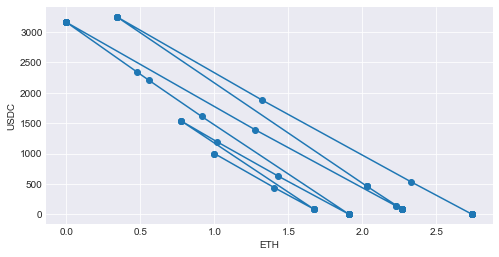

In [14]:
#plt.scatter(x=ethamt_r, y=usdcamt_r)
print(f"t={0:3.1f}: {ethamt_r[0]:4.1f} ETH {usdcamt_r[0]:6.0f} USDC (value {ethamt_r[0]*path[0]+usdcamt_r[0]:6.1f} USDC)")
print(f"t={1:3.1f}: {ethamt_r[-1]:4.1f} ETH {usdcamt_r[-1]:6.0f} USDC (value {ethamt_r[-1]*path[-1]+usdcamt_r[-1]:6.1f} USDC)")
plt.plot(ethamt_r, usdcamt_r, "-o")
plt.xlabel("ETH")
plt.ylabel("USDC")
plt.grid()

t=1.0:  2.7 ETH      0 USDC (value 3003.2 USDC)


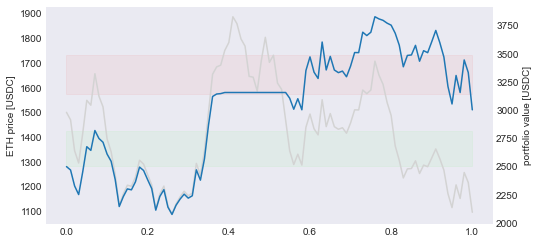

In [15]:
value_r = ethamt_r * path + usdcamt_r
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(time_r, path, color="lightgrey")
ax1.fill_between(time_r, p_buy_a, p_buy_b, color="lightgreen", alpha=0.1)
ax1.fill_between(time_r, p_sell_a, p_sell_b, color="lightcoral", alpha=0.1)
ax2.plot(time_r, value_r)
plt.xlabel("time")
ax2.set_ylabel("portfolio value [USDC]")
ax1.set_ylabel("ETH price [USDC]")
print(f"t={1:3.1f}: {ethamt_r[-1]:4.1f} ETH {usdcamt_r[-1]:6.0f} USDC (value {ethamt_r[-1]*path[-1]+usdcamt_r[-1]:6.1f} USDC)")
pass